<a href="https://colab.research.google.com/github/ritwiks9635/Object_Recognition_And_Detection-/blob/main/Face_Detection_using_RESnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Face Detection**

In [1]:
#https://www.kaggle.com/datasets/sbaghbidi/human-faces-object-detection

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/sbaghbidi/human-faces-object-detection/human-faces-object-detection.zip

In [25]:
import cv2
import time
import torch
import shutil
import random
import pandas as pd
import numpy as np
from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [5]:
batch_size = 4
img_size = 256

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

class_names = ["background", "Face"]
num_classes = 2

cuda


In [6]:
csv_file = "/content/faces.csv"

df = pd.read_csv(csv_file)
df.head()
#print(len(df))

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


###**Split Dataset**

In [7]:
def train_val_test_split(csv_file, split = 0.15):
    df = pd.read_csv(csv_file)

    df = df.sample(n = 500, random_state = 7)

    df.sample(frac = 1)
    len_df = len(df)

    split_ratio = int(len_df * (1 - split))

    train_val_df = df[: split_ratio]
    test_df = df[split_ratio :]

    len_train_val = len(train_val_df)
    val_split_ratio = int(len_train_val * (1 - split))

    train_df = train_val_df[: val_split_ratio]
    valid_df   = train_val_df[val_split_ratio :]


    return train_df, valid_df, test_df

In [8]:
train_df, valid_df, test_df = train_val_test_split(csv_file)

In [9]:
print("Total Train Data :: ", len(train_df))
print("Total Valid Data :: ", len(valid_df))
print("Total Test Data :: ", len(test_df))

Total Train Data ::  361
Total Valid Data ::  64
Total Test Data ::  75


In [10]:
# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well

class Averager:
    """""
    this class keeps track of the training and validation loss values...
    and helps to get the average for each epoch as well
    """""

    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

##**Prepare and Load Data**

In [12]:
class PrepareData(torch.utils.data.Dataset):
      def __init__(self, dataset, width, height, img_dir = "/content/images"):
          self.dataset = dataset
          self.width = width
          self.height = height
          self.img_dir = img_dir
          self.set_img_names = self.dataset["image_name"].tolist()
          self.img_path = glob(f"{self.img_dir}/*.jpg")
          self.all_images = [img_path.split("/")[-1] for img_path in self.img_path]
          self.all_images = sorted(self.all_images)

          self.images = []
          for i in self.set_img_names:
              for j in self.all_images:
                  if i == j:
                      self.images.append(i)

      def __getitem__(self, idx):
          img_name = self.images[idx]
          img_path = os.path.join(self.img_dir, img_name)

          image = cv2.imread(img_path)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
          img_resize = cv2.resize(image, (self.width, self.height))
          img_resize /= 255.0

          img_resize = np.transpose(img_resize, (2, 0, 1))


          boxes = []
          labels = []

          filtered_df = self.dataset.loc[self.dataset['image_name'] == img_name]
          for i in range(len(filtered_df)):

              # xmax = left corner x-coordinates
              xmin = int(filtered_df['x0'].iloc[i])
              # xmax = right corner x-coordinates
              xmax = int(filtered_df['x1'].iloc[i])
              # ymin = left corner y-coordinates
              ymin = int(filtered_df['y0'].iloc[i])
              # ymax = right corner y-coordinates
              ymax = int(filtered_df['y1'].iloc[i])

              image_width = int(filtered_df['width'].iloc[i])
              image_height = int(filtered_df['height'].iloc[i])

              # resize the bounding boxes according to the...
              # ... desired `width`, `height`
              xmin_final = (xmin/image_width)*self.width
              xmax_final = (xmax/image_width)*self.width
              ymin_final = (ymin/image_height)*self.height
              yamx_final = (ymax/image_height)*self.height

              boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
              labels.append(1) # 1 because there is only one class

          # bounding box to tensor
          boxes = torch.as_tensor(boxes, dtype=torch.float32)

          # area of the bounding boxes
          area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

          # crowd instances
          if boxes.shape[0] > 1:
              iscrowd = torch.ones((boxes.shape[0],), dtype=torch.int64)
          else:
              iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

          # label to tensor
          labels = torch.as_tensor(labels, dtype=torch.int64)

          # prepare the final `target` dictionary
          target = {}
          target["boxes"] = boxes
          target["labels"] = labels
          target["area"] = area
          target["iscrowd"] = iscrowd
          image_id = torch.tensor([idx])
          target["image_id"] = image_id

          return img_resize, target

      def __len__(self):
          return len(self.set_img_names)

In [13]:
train_dataset = PrepareData(train_df, img_size, img_size)
valid_dataset = PrepareData(valid_df, img_size, img_size)


train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = batch_size,
        shuffle = True,
        num_workers = 0,
        collate_fn = collate_fn)


valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size = batch_size,
        shuffle = False,
        num_workers = 0,
        collate_fn = collate_fn)

In [14]:
len(train_dataset)

361

In [15]:
for i, j in train_dataset:
    print(i.shape)
    break

(3, 256, 256)


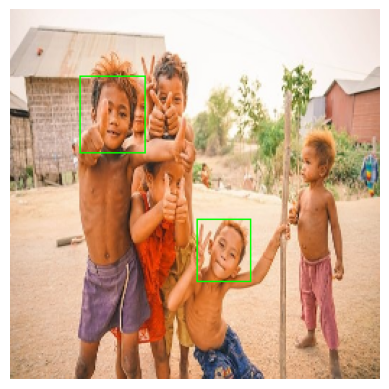

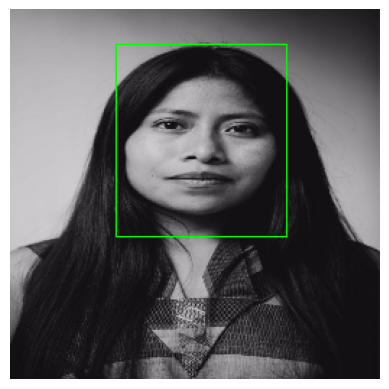

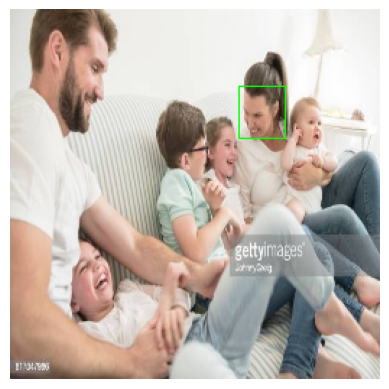

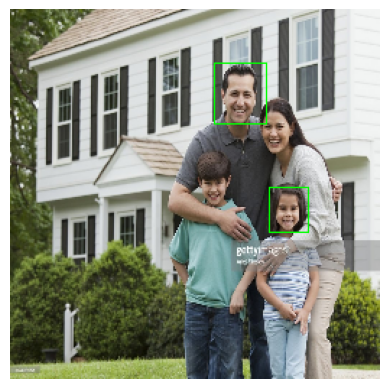

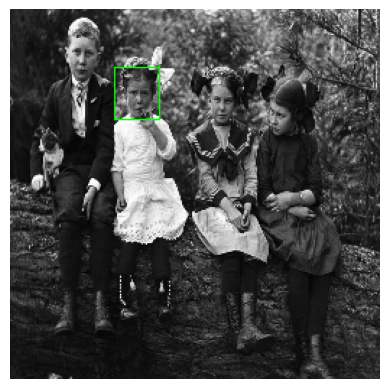

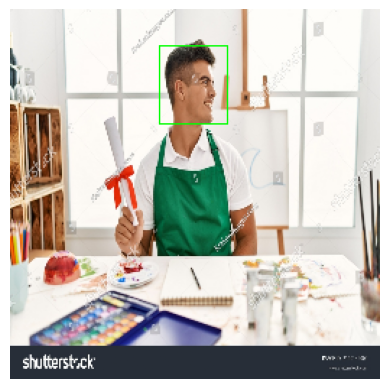

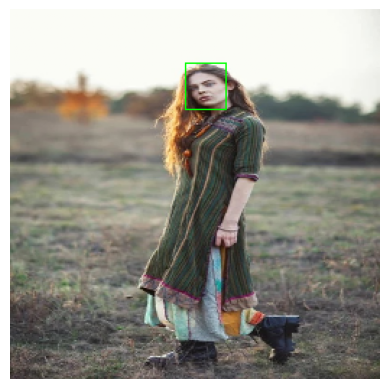

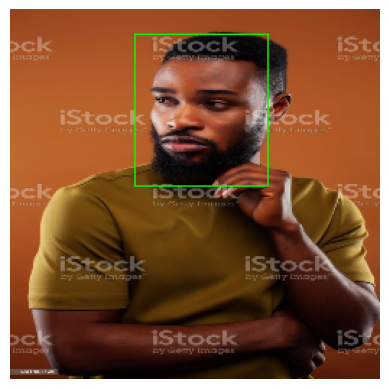

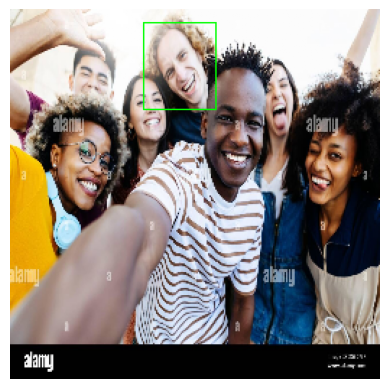

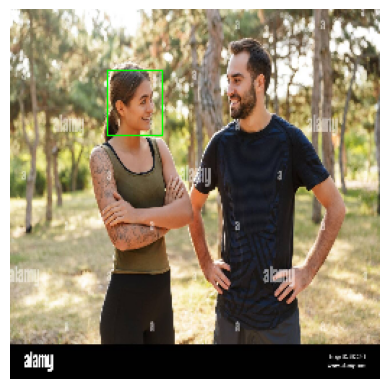

In [16]:
def visualize_sample(image, target):
    for box in target['boxes']:
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            (0, 255, 0), 1)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

NUM_SAMPLES_TO_VISUALIZE = 10
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    image, target = train_dataset[i]
    image = np.transpose(image, (1, 2, 0))
    visualize_sample(image, target)

###**Build Model**

In [17]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights = "DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

###**Function for Running Training Iterations**

In [18]:
def train(train_data_loader, model):
    print("training")
    global train_iter
    global train_loss_list

    progress_bar = tqdm(train_data_loader, total = len(train_data_loader))

    for i, data in enumerate(progress_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(torch.from_numpy(image).to(device) for image in images)
        targets = [{k : v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_iter += 1

        progress_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

###**Function for Running Validation Iterations**

In [21]:
def validate(valid_data_loader, model):
    print("validation")
    global valid_iter
    global valid_loss_list

    progress_bar = tqdm(valid_data_loader, total = len(valid_data_loader))

    for i, data in enumerate(progress_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(torch.from_numpy(image).to(device) for image in images)
        targets = [{k : v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        valid_loss_list.append(loss_value)
        valid_loss_hist.send(loss_value)


        valid_iter += 1

        progress_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return valid_loss_list

###**Training the Model**


EPOCH 1 of 10
training


  0%|          | 0/91 [00:00<?, ?it/s]

validation


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #1 train loss: 0.304
Epoch #1 validation loss: 0.187
Took 1.245 minutes for epoch 1

EPOCH 2 of 10
training


  0%|          | 0/91 [00:00<?, ?it/s]

validation


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #2 train loss: 0.173
Epoch #2 validation loss: 0.149
Took 1.231 minutes for epoch 2

EPOCH 3 of 10
training


  0%|          | 0/91 [00:00<?, ?it/s]

validation


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #3 train loss: 0.142
Epoch #3 validation loss: 0.135
Took 1.225 minutes for epoch 3

EPOCH 4 of 10
training


  0%|          | 0/91 [00:00<?, ?it/s]

validation


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #4 train loss: 0.131
Epoch #4 validation loss: 0.129
Took 1.220 minutes for epoch 4

EPOCH 5 of 10
training


  0%|          | 0/91 [00:00<?, ?it/s]

validation


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #5 train loss: 0.120
Epoch #5 validation loss: 0.136
Took 1.223 minutes for epoch 5

EPOCH 6 of 10
training


  0%|          | 0/91 [00:00<?, ?it/s]

validation


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #6 train loss: 0.111
Epoch #6 validation loss: 0.118
Took 1.228 minutes for epoch 6

EPOCH 7 of 10
training


  0%|          | 0/91 [00:00<?, ?it/s]

validation


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #7 train loss: 0.100
Epoch #7 validation loss: 0.119
Took 1.224 minutes for epoch 7

EPOCH 8 of 10
training


  0%|          | 0/91 [00:00<?, ?it/s]

validation


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #8 train loss: 0.094
Epoch #8 validation loss: 0.118
Took 1.222 minutes for epoch 8

EPOCH 9 of 10
training


  0%|          | 0/91 [00:00<?, ?it/s]

validation


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #9 train loss: 0.089
Epoch #9 validation loss: 0.123
Took 1.221 minutes for epoch 9

EPOCH 10 of 10
training


  0%|          | 0/91 [00:00<?, ?it/s]

validation


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #10 train loss: 0.084
Epoch #10 validation loss: 0.125
Took 1.224 minutes for epoch 10


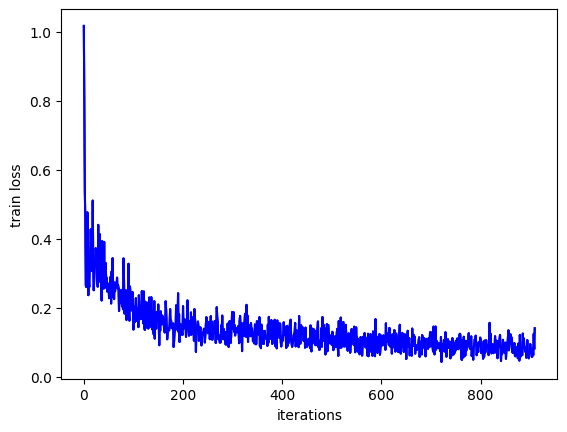

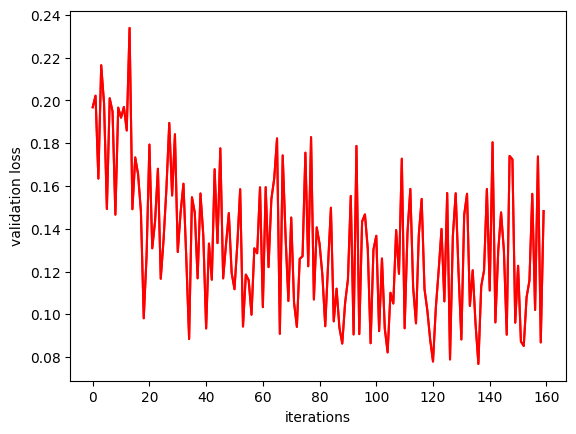

In [24]:
NUM_EPOCHS = 10 # number of epochs to train for

# initialize the model and move to the computation device
model = get_model(num_classes)
model = model.to(device)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# initialize the Averager class
train_loss_hist = Averager()
valid_loss_hist = Averager()
train_iter = 1
valid_iter = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
valid_loss_list = []
# name to save the trained model with
MODEL_NAME = 'model'

# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    valid_loss_hist.reset()

    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)

    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation loss: {valid_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")

    if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
        # create two subplots, one for each, training and validation
        figure_1, train_ax = plt.subplots()
        figure_2, valid_ax = plt.subplots()
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"/content/train_loss_{epoch+1}.png")
        figure_2.savefig(f"/content/valid_loss_{epoch+1}.png")
        torch.save(model.state_dict(), f"/content/model{epoch+1}.pth")

train_ax.plot(train_loss, color='blue')
train_ax.set_xlabel('iterations')
train_ax.set_ylabel('train loss')

valid_ax.plot(val_loss, color='red')
valid_ax.set_xlabel('iterations')
valid_ax.set_ylabel('validation loss')
plt.show()

###**Prediction**

Total Test images ::  75


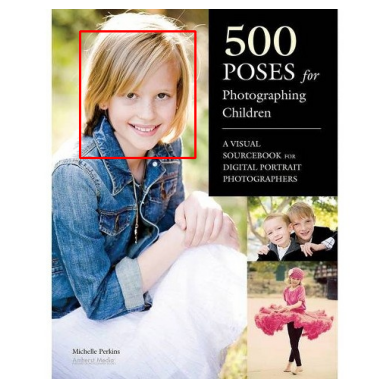

Image 8 done...
--------------------------------------------------


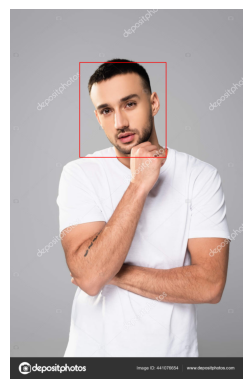

Image 72 done...
--------------------------------------------------


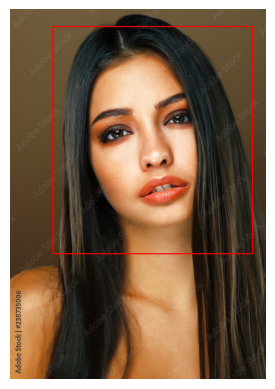

Image 40 done...
--------------------------------------------------


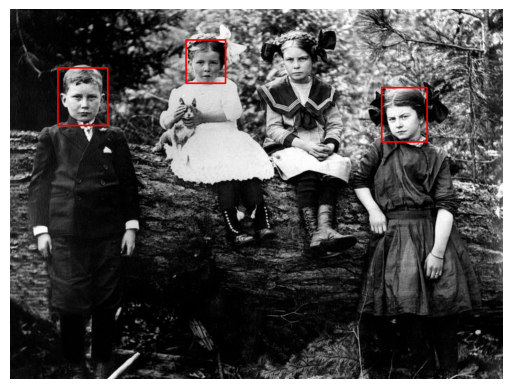

Image 29 done...
--------------------------------------------------


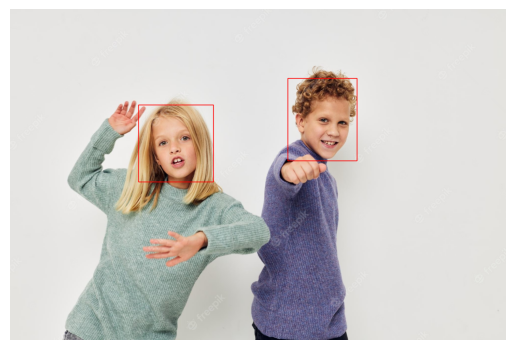

Image 16 done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE


In [54]:
model.eval()

threshold = 0.8

test_img_names = test_df["image_name"].tolist()
img_dir = "/content/images"

img_paths = glob(f"{img_dir}/*.jpg")
all_imgs = sorted([image.split("/")[-1] for image in img_paths])

test_images = []

for i in test_img_names:
    for j in all_imgs:
        if i == j:
            test_images.append(os.path.join(img_dir, i))


print("Total Test images :: ", len(test_images))

for i in random.sample(range(len(test_images)), 5):
    image = cv2.imread(test_images[i])
    origi_img = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image = np.transpose(image, (2, 0, 1))
    #print(image.shape)
    image = torch.tensor(image, dtype = torch.float).cuda()

    image = torch.unsqueeze(image, 0)
    #print(image.shape)
    with torch.no_grad():
        outputs = model(image)

    outputs = [{k : v.to("cpu") for k, v in f.items()} for f in outputs]


    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= threshold].astype(np.int32)
        draw_boxes = boxes.copy()

        # draw the bounding boxes
        for j, box in enumerate(draw_boxes):
            cv2.rectangle(origi_img,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (0, 0, 255), 2)
        image_rgb = cv2.cvtColor(origi_img, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()
    print(f"Image {i+1} done...")
    print('-'*50)
print('TEST PREDICTIONS COMPLETE')